
<h1 align="center">Práctica 5. Medida empírica de la complejidad computacional</h1>
<h3 style="display:block; margin-top:5px;" align="center">Programación</h3>
<h3 style="display:block; margin-top:5px;" align="center">Grado en Ciencia de Datos</h3>    
<h3 style="display:block; margin-top:5px;" align="center">Universitat Politècnica de València</h3>
<h3 style="display:block; margin-top:5px;" align="center">Curso 2021-22</h3>
<br>

## Índice
1. ### [Objetivos](#objetivos)
1. ### [Estructura de un experimento de medida](#estructura_exp)
1. ### [Generación de datos de entrada para distintas tallas e instancias](#gen_datos)
1. ### [Función de medida de tiempos](#fun_medida)
1. ### [Actividad 1: implementar función de medida de tiempos](#act1)
1. ### [Actividad 2: medida de tiempos de un conjunto de algoritmos](#act2)
1. ### [Actividad 3: visualización gráfica de los tiempos medidos](#act3)
1. ### [Actividad 4: medida de tiempos de vaciar una lista usando `pop`](#act4)
1. ### [Actividad 5: obtención de funciones de coste que se aproximen a los tiempos medidos](#act5)
1. ### [Actividad 6: medida y visualización de métodos directos de ordenación](#act6)
1. ### [Actividad 7: medida y visualización de `mergeSort`](#act7)



<a id='objetivos'></a>
## Objetivos:
- Introducir el análisis de algoritmos en el laboratorio, usando un entorno real de programación: análisis empírico.
- Representar gráficamente el crecimiento de los costes temporales medidos para confirmar los resultados teóricos: uso de la librería **matplotlib.pyplot**.
- Inferir funciones aproximadas que definan el comportamiento temporal de un algoritmo: uso de la librería **scypy.optimize**.
- Usar las funciones inferidas para realizar predicciones.

<a id='estructura_exp'></a>
## Estructura de un experimento de medida

El análisis empírico se realiza tras el análisis teórico. Al diseñar un análisis empírico se deben tomar en consideración los siguientes puntos:

- **La medida de tiempo debe hacerse para varias tallas:** el objetivo es obtener una función de coste que tenga como parámetro la talla del problema; por tanto, deben emplearse diversas tallas para obtener el perfil de esa función.

- **Cuando existan instancias significativas, deberán medirse separadamente:** los casos mejor, peor y promedio presentan habitualmente distintas tasas de crecimiento y, por tanto, distinta función de coste; así pues, deben medirse de manera separada siempre y cuando se determine, con un análisis del código, que existen instancias significativas.

- **Para obtener resultados consistentes se deben tomar varias medidas,** una única medida por talla no es significativa, ya que:

    - El reloj para realizar la medición (ej: `time.process_time()`) puede tener una precisión limitada. Si medimos algo de poca duración, el error relativo será más alto que si lo que medimos tarda mucho más.

    - La  medida puede verse afectada por condiciones del entorno (por ejemplo, la ejecución de otros procesos en el ordenador).

    - Es mejor medir varias instancias de la misma talla, siempre que esto sea posible, para que la medición no dependa de condiciones particulares de una sola instancia.
    
    > **Nota:** En esta práctica, para simplificar, generaremos **una única instancia**. Generar varias instancias (particularmente en el caso de ordenar vectores con valores aleatorios) daría lugar a resultados más robustos, pero complicaría más el código a realizar y la práctica propuesta.
   
Por tanto, para garantizar resultados correctos se deben tomar varias medidas, promediándolas. Dicha media puede considerarse un resultado significativo.


> **Nota:** El número de medidas a realizar para cada talla y tipo de instancia dependerá del tiempo de ejecución, tal y como se explica más abajo.


<a id='gen_datos'></a>
## Generación de datos de entrada para distintas tallas e instancias

Cuando el algoritmo a medir tiene como dato de entrada una lista, vector o array, la talla del algoritmo será, generalmente, el tamaño de dicha lista, vector o array. Por tanto, conviene disponer de funciones que, dada una talla, nos generen automáticamente una lista de dicho tamaño.

Además, si existen distintas instancias significativas (el coste del algoritmo varía significativamente dependiendo de los datos de entrada), entonces necesitamos generar datos de entrada para cada una de estas instancias.

**Por ejemplo,** para un algoritmo de ordenación particular (esto **no** sucede con todos los algoritmos de ordenación, pero sí con alguno de los que vamos a medir):

- El caso *mejor* podría darse cuando la lista de entrada ya está ordenada,
- El caso *peor* cuando está ordenada al revés (en modo decreciente),
- El caso *promedio* cuando contiene valores aleatorios.

A continuación se definen tres funciones para generar listas de una talla dada en las tres situaciones planteadas:
- Lista con valores en orden creciente
- Lista con valores en orden decreciente
- Lista con valores aleatorios

> **Atención:** Observa que en el código de la celda siguiente aparece
>
> ```Python
> import algorithms as alg
> ```
>
> Se refiere a un fichero `algorithms.py` que debes descargar junto a 
> este notebook y dejarlo en la misma carpeta. Este fichero contiene funciones que implementan cada uno de los algoritmos que vamos a medir.
>
> Debes abrirlo y estudiarlo para entender mejor la práctica.

In [1]:
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
import algorithms as alg


def generate_increasing_vector(vectorsize):
    return list(range(vectorsize))

def generate_decreasing_vector(vectorsize):
    return list(range(vectorsize-1,-1,-1))

def generate_random_vector(vectorsize):
    return [random.randrange(0, 10000000) for i in range(vectorsize)]


<a id='fun_medida'></a>
## Función de medida de tiempos

Para nuestros experimentos necesitaremos también una función genérica que nos permita medir el tiempo de ejecución de un algoritmo determinado, para unos datos de entrada determinados.

Esta función debería tener las siguientes características:

- Debe recibir como parámeros:
    - La función que implementa el algoritmo a medir. 
    - Un vector (lista o array) con los datos de entrada.
    
      > **Nota:** Estamos asumiendo que todas las funciones que le pasemos a esta función reciben como único argumento una lista Python. Realmente no hace falta que sea una lista pero sí un argumento que tenga un método `.copy()` para hacerle una copia.
      
- Debe repetir la medición un *número suficiente* de veces y devolver el promedio de todas las medidas. 
- En lugar de fijar el número de veces que queremos repetir la medida, fijaremos el tiempo **mínimo** que queremos estar midiendo. Esto es, repetiremos el proceso de medida mientras el tiempo total empleado para todas las medidas no supere cierto umbral.
- Utilizaremos la función `time.process_time()` que devuelve el tiempo de CPU (en segundos) que lleva consumido nuestro proceso (proceso viene a ser equivalente a "programa en ejecución") hasta el momento.

<a id='act1'></a>
## Actividad 1: implementar función de medida de tiempos

Completa la función `measure_time` que aparece a continuación. Esta función debe ejecutar, durante un mínimo de 0.5 segundos, tantas veces como pueda, el algoritmo a medir para unos datos de entrada dados. El tiempo de una ejecución del algoritmo será el tiempo total que hemos estado midiendo dividido por el número de ejecuciones. 

### Parámetros:
- `function`: función en la que se encuentra implementado el algoritmo a medir.
- `vect`: vector (lista o array) con los datos de entrada del algoritmo a medir.

### Devuelve:
- El tiempo promedio (en segundos) que tarda en ejecutarse la función `function` con los datos de entrada `vect`.

### Algoritmo:
- `t_accum` = tiempo de proceso acumulado a lo largo de las ejecuciones de la función
`function` pasándole una copia de `vect`.
- `repeticiones` contará el número de veces que hemos ejecutado `function`.
- mientras `t_accum < 0.5` segundos
    - Crear una copia del vector de entrada (método `copy`)
    - Invocar a la función `function` que queremos medir pasándole como parámetro la copia del vector.
    > **Nota:** debemos acumular en `t_accum` el tiempo de ejecución de esta función. Para ello debemos llamar a `time.process_time()` antes y después, la diferencia será una estimación de ese tiempo de ejecución.
    - Actualizar adecuadamente `repeticiones`.
- Devolver el tiempo promedio (tiempo total / número de medidas realizadas)

In [2]:
import time

def measure_time(function, vect):
    t_accum = 0
    repeticiones = 0
    entrada = vect.copy()
    
    # COMPLETAR
    
    while t_accum < 0.5:
        vect = entrada.copy()
        t1 = time.process_time()
        function(vect)
        t2 = time.process_time()
        t_accum += (t2-t1)
        repeticiones += 1
    return t_accum/repeticiones


### Test
Comprueba que la función implementada se ejecuta sin errores. Para ello, genera un vector aleatorio de tamaño 10000 y muestra el tiempo que tarda la función **sort** de **numpy** (**np.sort**) en ordenarlo.

In [3]:
v = generate_random_vector(10000)
# COMPLETAR
measure_time(np.sort, v)

0.0019157088122605363

<a id='act2'></a>
## Actividad 2: medida de tiempos de un conjunto de algoritmos

Ahora que ya tenemos una función para medir el tiempo de ejecución, vamos a aplicarlo a un conjunto dado de algoritmos para distintas tallas y tipos de instancia.

Para ello se propone que implementes la función `measure_algorithms` que describimos a continuación:

### Parámetros de entrada:

- `algorithms`: es un **diccionario** que contiene como clave de cada entrada el nombre del algoritmo a medir y como valor la función Python que lo implementa.
- `gen_instances`: otro **diccionario** que tiene como clave una cadena que describe el tipo de generación de instancia y como valor una función que recibe una talla y genera un vector de esa talla. En nuestro caso, el valor será alguna de las siguientes funciones:

    - `generate_random_vector` genera valores aleatorios
    - `generate_increasing_vector` genera valores crecientes
    - `generate_decreasing_vector` genera valores decrecientes
    
- `sizes`: una **lista** con las tallas para las que se desea medir tiempos.

### Devuelve:

- Un **diccionario** que contiene como clave de cada entrada la combinación de los nombres (separados por "`:`") del algoritmo que se ha medido y el tipo de instancia generada. El valor asociado a cada entrada es la lista con los tiempos medidos para cada una de las tallas del vector `sizes`.


### Ejemplo:

Un ejemplo de uso de la función podría ser el siguiente:

```python
algorithms = {'Ordenacion numpy'  : np.sort,
              'Ordenacion ins. directa' : alg.insertionSort }
instances = { 'mejor' : generate_increasing_vector,
              'peor' : generate_decreasing_vector }
sizes = [1000, 2000, 3000, 4000, 5000]
ydata = measure_algorithms(algorithms, instances, sizes)
```

Una posible salida para esa entrada sería:

```
{'Ordenacion numpy:mejor': [8.667703084921863e-05, 0.00015043693862817274,
                            0.00022507754635463063, 0.00029896581123061154,
                            0.0003713250296735766],
'Ordenacion ins. directa:mejor': [0.0001630165749674007, 0.00032552819661458367,
                                  0.0005137583531827937, 0.0006722014408602206,
                                  0.0007490311407185391],
'Ordenacion numpy:peor': [8.25168207920845e-05, 0.00015562347728687712,
                          0.00024043783076922284, 0.00031401251442911,
                          0.00039296361695449034],
'Ordenacion ins. directa:peor': [0.08933096233333367, 0.3769609520000001,
                                 0.8582383829999998, 1.5401752769999995,
                                 2.4022259240000015]}
```

### Algoritmo:
- Crear un diccionario `measures` cuyas claves sean cadenas de texto resultantes de concatenar el nombre de cada algoritmo (claves del diccionario `algorithms`) con el nombre de cada tipo de instancia (claves del diccionario `gen_instances`), separados por "`:`". El valor asociado a cada clave será, inicialmente, una lista vacía. Por ejemplo, si los algoritmos son `'alg1'` y `'alg2'` y las instancias `'peor'` y `'mejor'`, entonces deberá crearse el diccionario `measures = {'alg1:mejor':[], 'alg1:peor':[], 'alg2:mejor':[], 'alg2:peor':[]}`. 

En estas listas vacías guardaremos más adelante los tiempos para distintas tallas de cada uno de los algoritmos en cada una de las instancias. Para ello:


- Para cada instancia del diccionario `gen_instances`:    
    - Para cada talla de la lista `sizes`:
        - Llamar a la función generadora de instancia y generar una instancia (una lista) para la talla dada.
        - Para cada algoritmo del diccionario `algorithms`:
             - Medir el tiempo de ejecución del algoritmo con la instancia generada.
             - Añadir (método `append`) esa medida en la lista correspondiente del diccionario `measures`.
- Devolver el diccionario `measures`

In [19]:
def measure_algorithms(algorithms, gen_instances, sizes):
    # Diccionario vacio
    measures = {}
    # Recorrer algorithms
    for algoritmo in algorithms:
        for tipo in gen_instances:
            # Lista vacia
            measures[f"{algoritmo}:{tipo}"] = []

    # Recorrer gen_instances        
    for clave,instancia in gen_instances.items():
        for talla in sizes:
            ins = instancia(talla)
            for clave2,algoritmo in algorithms.items():
                tiempo = measure_time(algoritmo,ins)
                s = clave2 + ':' + clave
                measures[f"{clave2}:{clave}"].append(tiempo)
            
    return measures


### Test

In [20]:
algorithms = {'Ordenacion numpy'  : np.sort,
              'Ordenacion ins. directa' : alg.insertionSort }
instances = { 'mejor' : generate_increasing_vector,
         'peor' : generate_decreasing_vector }
sizes = [1000, 2000, 3000, 4000, 5000]
ydata = measure_algorithms(algorithms, instances, sizes)
print(ydata)

{'Ordenacion numpy:mejor': [0.00014310246136233542, 0.00039032006245121, 0.0005219206680584551, 0.0005208333333333333, 0.0007132667617689016], 'Ordenacion numpy:peor': [0.00015508684863523573, 0.00035561877667140827, 0.0003748125937031484, 0.0004784688995215311, 0.0008547008547008547], 'Ordenacion ins. directa:mejor': [0.00036656891495601173, 0.0005868544600938967, 0.0009380863039399625, 0.001201923076923077, 0.0015432098765432098], 'Ordenacion ins. directa:peor': [0.20833333333333334, 0.765625, 1.78125, 3.09375, 5.9375]}


<a id='act3'></a>
## Actividad 3: visualización gráfica de los tiempos medidos

Los resultados numéricos usualmente se interpretan mejor con su representación gráfica. En el tutorial `introduccion_matplotlib.ipynb`, disponible en PoliformaT, puedes encontrar una pequeña introducción a la visualización de datos mediante `matplotlib`.

A continuación debes escribir una función que genere una gráfica en la que se representan los tiempos medidos en una serie de algoritmos (eje y) para distintas tallas (eje x). Debe generar una gráfica de puntos (**sin unir** mediante líneas cada valor representado).

### Parámetros:
- `xdata`: lista con las tallas para las que se han realizado medidas.
- `ydata`: diccionario que contiene como clave de cada entrada el nombre e instancia del algoritmo medido y como valor una lista (del mismo tamaño que `xdata`) con los tiempos medidos. 

In [6]:
def plot_data(xdata, ydata):
    # COMPLETAR
    for i in ydata:
        plt.scatter(xdata, ydata[i])

### Test
Para comprobar el correcto funcionamiento, prueba visualizar con la función que acabas de implementar los siguientes datos:

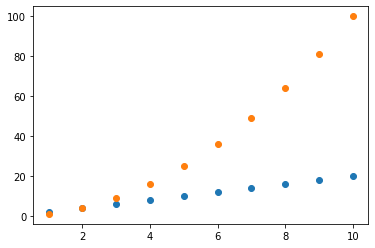

In [7]:
xdata_test = [1,2,3,4,5,6,7,8,9,10]
ydata_test = {'Alg1:mejor' : [2,4,6,8,10,12,14,16,18,20],
              'Alg1:peor' : [1,4,9,16,25,36,49,64,81,100]}
plot_data(xdata_test, ydata_test)

<a id='act4'></a>
## Actividad 4: medida de tiempos de vaciar una lista usando `pop`

En esta actividad vamos a medir el tiempo que cuesta vaciar una lista Python usando el método `pop` que extrae un elemento de una lista usando dos versiones:

- Vaciar los elementos del final (usando `lista.pop()` sin argumentos).
- Hacer lo mismo pero quitando los elementos iniciales (usando `lista.pop(0)`).

A pesar de que ambos algoritmos tienen como única diferencia el argumento `0` de la llamada a `pop()`, el coste varía sustancialmente porque eliminar un elemento del final tiene coste constante $\Theta(1)$ (en esta caso también se podría decir $O(1)$), mientras que eliminar un elemento del inicio (`lista.pop(0)`) requiere copiar el resto de elementos una posición hacia atrás, y eso, para una lista de longitud $n$, tiene coste $\Theta(n)$. Para más información puedes consultar [el siguiente enlace](https://wiki.python.org/moin/TimeComplexity).

### Experimento a realizar:

Dados los diccionarios `pop_algorithms`con los algoritmos que se desean medir y `gen_instances`con el tipo de instancia que se quiere medir:

1. Llama adecuadamente a la función `measure_algorithms` para que realice mediciones de tiempos para tallas entre 5000 y 50000, con incrementos de 5000 en 5000.
2. Invoca a la función `plot_data` que has completado en la actividad anterior pasándole el diccionario devuelto por `measure_algorithms`.


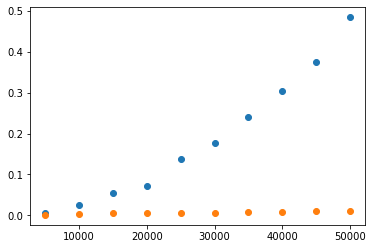

In [8]:
# Diccionario con nombre_algoritmo : funcion_que_lo_implementa
pop_algorithms =  {'empty_front'  : alg.empty_front,
                   'empty_ending' : alg.empty_ending }

# Diccionario con los tipos de generación de las instancias a medir
gen_instances = { 'increasing' : generate_increasing_vector }


# COMPLETAR
tallas = range(5000,50001,5000)
m = measure_algorithms(pop_algorithms,gen_instances,tallas)

plot_data(tallas,m)


<a id='act5'></a>
## Actividad 5: obtención de funciones de coste que se aproximen a los tiempos medidos

Una vez obtenidos y visualizados los datos, resulta interesante encontrar alguna función matemática que se ajuste a los valores obtenidos.

> **Observa** que esto nos permite estimar el coste para una talla que no hayamos medido de forma experimental.

Para obtener una función matemática que se ajuste con el menor error posible a nuestros datos, es posible usar la función **curve_fit** disponible en el módulo **scypy.optimize**. En el tutorial `introduccion_ajuste_curvas.ipynb`, disponible en PoliformaT, puedes encontrar una explicación de cómo hacerlo.

### 5.1. Definición de las funciones de ajuste

Lo primero que debemos hacer es definir las funciones Python que implementen funciones matemáticas determinadas. Estas funciones deben recibir el valor (o valores) de *x*, así como los coeficientes de la función matemática, y deben devolver el valor (o valores) de *y* obtenidos con *f(x)* para los coeficientes dados.

A continuación puedes ver la definición de 3 funciones Python que implementan una función (matemática) lineal, otra cuadrática y otra de tipo $n \log n$. Observa que cada función Python recibe el valor (o valores) de $x$ y los parámetros propios la función matemática que representa.

> **Nota:** es importante que el parámetro $x$ vaya siempre en primer lugar.

In [9]:
def linear(x, a, b):
     return (a * x) + b

def quadratic(x, a, b, c):
     return a * x**2 + b * x + c
    
def nlogn(x, a, b):
     return a * x * np.log(x) + b

### 5.2. Ajuste mediante `curve_fit`

A modo de ejemplo, vamos a definir una serie de valores `y` que sigan aproximadamente (con cierto ruido) la función $x^2 + 3x - 5$ y vamos a plotearlos. 

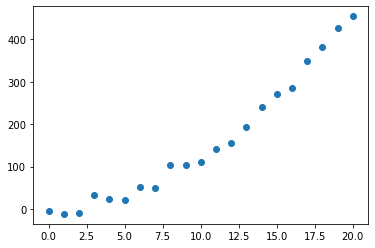

In [10]:
# Genera la lista x = [0.0, 1.0, 2.0, ..., 20.0]
x = [float(i) for i in range(21)] 

# A partir de la lista anterior, genera una lista con y = x^2 + 3x -5 + un valor 
# aleatorio entre -20 y 20
y = [quadratic(xx, 1, 3, -5) + random.uniform(-20, 20) for xx in x] 

plt.scatter(x, y)

A continuación, vamos a buscar la función cuadrática que mejor se ajuste a estos valores

Parámetros de la función de ajuste: [ 1.07175731  1.99521126 -5.89189827]


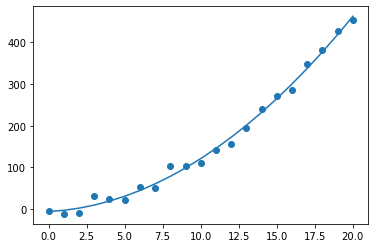

In [11]:
import scipy.optimize as opt

# Obtenemos los parámetros de la función cuadrática que mejor se ajuste a los puntos x,y
params, cov = opt.curve_fit(quadratic, x, y)

# Mostramos los parámetros de la función de ajuste (en nuestro caso coeficientes A,B,C de la función Y = AX^2 + BX + C)
print('Parámetros de la función de ajuste:', params)

# Calculamos los valores de y ajustados a la función definida por 'params'
yfit = quadratic(np.array(x), *params)

# Ploteamos los valores originales y los ajustados
plt.scatter(x, y)
plt.plot(x, yfit)
plt.show()

- **Observa** los parámetros de la función obtenida y compáralos con la función original que usamos para generar los datos ($X^2 + 3X -5$)
- **Prueba** generar los datos con menos ruido (p. ej. valor aleatorio entre [-10,10] en lugar de [-20,20]), ajusta de nuevo los datos y observa los nuevos parámetros de la función de ajuste. ¿Se parece ahora más a la usada para generar los datos?

### 5.3. Función `plot_and_fit`

A continuación se proporciona el código de la función `plot_and_fit` que usaremos en los siguientes experimentos. Esta función recibe 3 argumentos:
- La lista de tallas `xdata`.
- El diccionario `ydata` que asocia a cada cadena una lista de valores medidos, uno para cada una de las tallas del vector `xdata`. Este diccionario es el que devuelve la función `measure_algorithms`.
- Otro diccionario `fit_functions` con exactamente las mismas claves que el diccionario `ydata` pero que tiene como valores funciones de ajuste como las descritas arriba (ej: `linear`, `quadratic`,...).

La función `plot_and_fit` que mostramos a continuación combina la funcionalidad del ajuste de curvas con el de dibujar las gráficas con `plt.plot`. Aunque es posible separar el ajuste de curvas de la visualización de las mismas, hemos combiando ambas funcionalidades para simplificar:

In [12]:
import scipy.optimize as opt

def plot_and_fit(xdata, ydata, fit_functions, points=100):
    markers = itertools.cycle("o.*+,")
    linestyles = itertools.cycle(('-','--','-.',':'))
    xdata = [float(x) for x in xdata]
    for name, y in ydata.items():
        plt.plot(xdata, y, marker=next(markers), linestyle='', label=name)
        ff = fit_functions[name]
        params, _ = opt.curve_fit(ff, xdata, y)
        xfit = np.array(xdata)
        xfit = np.linspace(xfit.min(),xfit.max(),points)
        yfit = ff(xfit, *params)
        print(params)
        plt.plot(xfit, yfit, linestyle=next(linestyles))
    plt.legend()
    plt.show()

### Test
Para comprobar el correcto funcionamiento, prueba visualizar con la función anterior los siguientes datos:

[ 2.0969697  -0.23333333]
[ 0.95454545  0.43939394 -0.66666667]


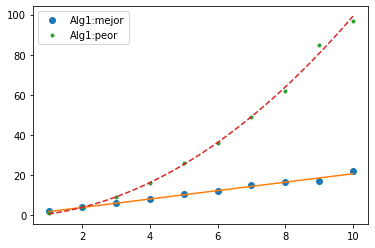

In [13]:
xdata_test = [1,2,3,4,5,6,7,8,9,10]
ydata_test = { 'Alg1:mejor' : [2,4,6,8,10.5,12,15,16.5,17,22],
               'Alg1:peor'  : [1,4,9,16,26,36,49,62,85,97] }
fit_functions = { 'Alg1:mejor' : linear,
                  'Alg1:peor' : quadratic }
plot_and_fit(xdata_test, ydata_test, fit_functions)

### 5.4. Encontrar funciones que se ajusten a las mediciones realizadas en la actividad 4

A continuación, invoca adecuadamente a la función `plot_and_fit` para ajustar los datos obtenidos en el experimento de la actividad 4 a una función lineal y cuadrática respectivamente. Visualiza tanto los valores medidos como las funciones ajustadas.

[1.80525864e-10 4.33867576e-07 1.81749887e-03]
[1.93552319e-07 9.66236485e-04]


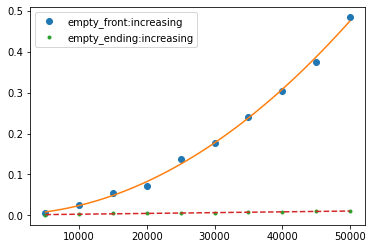

In [14]:
fit_func = {'empty_front:increasing' : quadratic,
            'empty_ending:increasing' : linear}

tallas = range(5000,50001,5000)
plot_and_fit(tallas,m,fit_func)

# COMPLETAR


<a id='act6'></a>
##  Actividad 6: medida y visualización de métodos directos de ordenación

Esta actividad es bastante sencilla puesto que se trata de repetir lo que ya hemos realizado en los puntos anteriores y solo cambia el tipo de algoritmo a medir. 

En primer lugar, completa el código siguiente para **medir** los tiempos de cómputo del algoritmo `insertionSort` con las tres instancias propuestas y **plotear** dichos tiempos (sin ajustar de momento mediante ninguna curva).

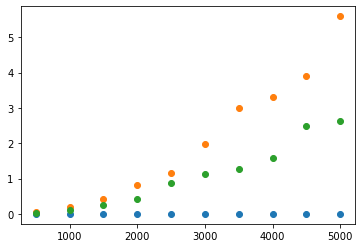

In [15]:
# Diccionario con nombre_algoritmo : funcion_que_lo_implementa
insort_algorithm =  {'insertionSort' : alg.insertionSort }

# Diccionario con los tipos de generación de las instancias a medir
insort_gen_instances = { 'increasing' : generate_increasing_vector,
                         'decreasing' : generate_decreasing_vector,
                         'random'     : generate_random_vector }

# Lista con las tallas a medir
insort_sizes = list(range(500,5000+1,500))

med = measure_algorithms(insort_algorithm,insort_gen_instances,insort_sizes)

plot_data(insort_sizes,med)

# COMPLETAR


Fíjate cómo crece el tiempo de cada instancia en la gráfica anterior y ajusta cada una de ellas con la función adecuada. Para ello, completa el siguiente diccionario y úsalo en la llamada a la función `plot_and_fit` para realizar el ajuste de curvas de los datos que acabas de obtener con las funciones de coste asintótico más adecuadas y su posterior visualización:

[2.92383549e-07 9.23266909e-06]
[ 2.15553974e-07 -1.74004422e-06 -2.90364615e-02]
[ 6.83173735e-05 -4.33791947e-01]


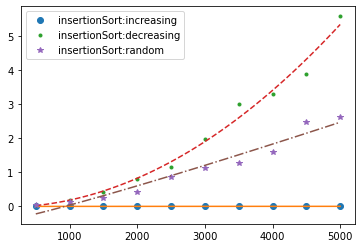

In [16]:
# COMPLETAR
# Crear diccionario
insort_fit_func = {'insertionSort:increasing': linear, 'insertionSort:decreasing': quadratic, 'insertionSort:random':nlogn}


plot_and_fit(insort_sizes,med,insort_fit_func)


# Plotear tiempos medidos y funciones de ajuste

<a id='act7'></a>
##  Actividad 7: medida y visualización de `mergeSort`

Una vez comparado el coste de ordenar distintos tipos de instancia con Inserción Directa, vamos a realizar un par de experimentos más:
- Comparar Inserción Directa con Mergesort para tallas pequeñas.
- Probar Mergesort para tallas un poco más altas (no las probamos con Inserción directa porque el tiempo subiría mucho).

Adicionalmente, también vamos a comparar con la implementación *nativa* de Python (que utiliza el algoritmo [Tim Sort](https://en.wikipedia.org/wiki/Timsort) relativamente *emparentado* con Mergesort y que, al estar implementado internamente en el intérprete de Python resulta **mucho más rápido** que los otros).

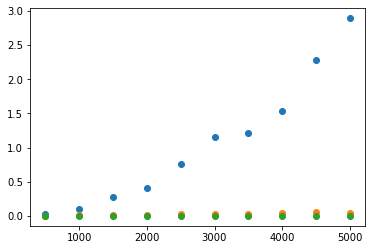

In [17]:
# Diccionario con nombre_algoritmo : funcion_que_lo_implementa
sort_algorithm = { 'insertionSort' : alg.insertionSort,
                   'mergeSort'     : alg.mergeSort,
                   'nativeSort'    : alg.nativeSort }

# Diccionario con los tipos de generación de las instancias a medir
sort_gen_instances = { 'random'     : generate_random_vector }


# COMPLETAR: mide los tiempos de cómputo para tallas entre 500 y 5000 con incrementos
# de 500 en 500 y plotea los resultados (sin ajustar mediante ninguna curva)
size = range(500,5001, 500)
med = measure_algorithms(sort_algorithm,sort_gen_instances,size)
plot_data(size,med)

En la gráfica que acabas de obtener apenas se puede distinguir el coste de `mergeSort` y el del sort nativo, así que vamos a realizar otro experimento sin utilizar `insertionSort` para poder aumentar la talla sin que el coste cuadrático de `insertionSort` lo vuelva prohibitivo:

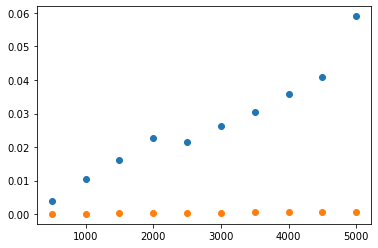

In [18]:
# Diccionario con nombre_algoritmo : funcion_que_lo_implementa
sort_algorithm = { 'mergeSort'     : alg.mergeSort,
                   'nativeSort'    : alg.nativeSort }

# Diccionario con los tipos de generación de las instancias a medir
sort_gen_instances = { 'random'     : generate_random_vector }

# COMPLETAR: mide los tiempos de cómputo para tallas entre 25000 y 250000 con incrementos
# de 25000 en 25000 y plotea los resultados ajustándolos a funciones logarítmicas
size = range(500,5001, 500)
med = measure_algorithms(sort_algorithm,sort_gen_instances,size)
plot_data(size,med)